In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax.numpy as jnp
from jax import random, vmap, grad, jit
from jax.ops import index, index_add, index_update
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [2]:
data = pd.read_csv('./data/txtdata.csv',header=None).rename(columns={0:'msg'})

(0, 74)

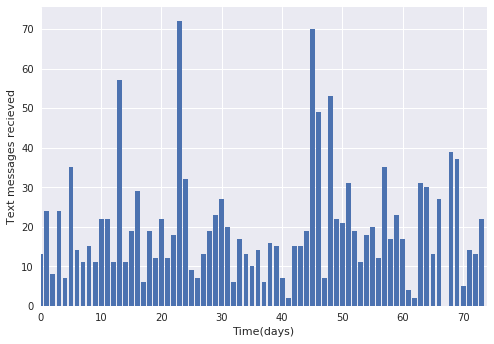

In [3]:
plt.bar(jnp.arange(len(data)),data.msg)
plt.ylabel("Text messages recieved")
plt.xlabel("Time(days)")
plt.xlim(0,len(data))

変化点はあるだろうか？    
変化点を見つけるためにベイズ的にモデリングをしようと思う。   
まず、1日あたりに受信するメッセージの分布がある時を境に変化したと考える。   

In [4]:
def model(data):
    alpha = (1. / data.mean())
    lambda1 = numpyro.sample("lambda1", dist.Exponential(rate=alpha))
    lambda2 = numpyro.sample("lambda2", dist.Exponential(rate=alpha))
    tau = numpyro.sample("tau", dist.Uniform(0,len(data)))
    out = jnp.where(jnp.arange(0,len(data))<tau,lambda1,lambda2)
    obs = numpyro.sample("obs",dist.Poisson(out),obs=data)
    
def guide(data):
    numpyro.sample("tau", dist.Categorical(jnp.full(n_count_data,1/n_count_data)))

    m1 = numpyro.param("m1", jnp.array(0.0))
    s1 = numpyro.param("s1", jnp.array(1.0))
    numpyro.sample("lambda_1", dist.Normal(m1, s1))
    m2 = numpyro.param("m2", jnp.array(0.0))
    s2 = numpyro.param("s2", jnp.array(1.0))
    numpyro.sample("lambda_2", dist.Normal(m2, s2))
    

In [5]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_,data=data.msg.values)

sample: 100%|██████████| 3000/3000 [00:09<00:00, 326.92it/s, 1023 steps of size 4.42e-04. acc. prob=0.96]


In [6]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   lambda1     17.58      0.54     17.58     16.61     18.37     38.61      1.01
   lambda2     22.76      0.89     22.77     21.17     24.13     29.95      1.04
       tau     43.80      1.00     44.08     42.19     45.00      9.78      1.18

Number of divergences: 0


In [7]:
samples = mcmc.get_samples()
N = samples['tau'].shape[0]
expected_texts_per_day = jnp.zeros(len(data))
for day in range(0, len(data)):
    ix = samples['tau'] > day
    expected_texts_per_day = index_update(expected_texts_per_day,
                                          index[day],
                                          (samples['lambda1'][ix].sum()+ samples['lambda2'][~ix].sum()) / N)

<BarContainer object of 74 artists>

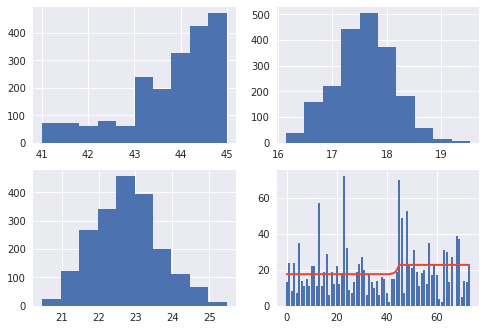

In [8]:
fig = plt.figure()
ax = fig.add_subplot(221)
ax.hist(mcmc.get_samples()['tau'])
ax = fig.add_subplot(222)
ax.hist(mcmc.get_samples()['lambda1'])
ax = fig.add_subplot(223)
ax.hist(mcmc.get_samples()['lambda2'])
ax = fig.add_subplot(224)
ax.plot(jnp.arange(0,len(data),1), expected_texts_per_day, lw=2, color="#E24A33",
         label="expected number of text-messages received")
plt.bar(jnp.arange(len(data)),data.msg.values)